In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import f1_score
from keras.utils import to_categorical
from keras import optimizers
from keras import regularizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.regularizers import l2
from keras import layers
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GRU, Bidirectional 
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from tqdm import tqdm
from langua import Predict
import gensim
import time
import re

Using TensorFlow backend.


# Data Preparation & Exploration:

In [2]:
# Load data to pandas df:
df = pd.DataFrame.from_csv('exportESP150k.csv', encoding='utf-8')

In [4]:
#Drop unnecessary columns
df.drop(['tx_id', 'author', 'parent_author', 'timestamp', 'json_metadata', 
         'title', 'title', 'lang'], axis=1, inplace = True, errors='ignore')

In [10]:
df

,body,words_pos_polarity,words_neg_polarity,emoji_pos_polarity,emoji_neg_polarity,word_emoji_pos_pol_diff,word_emoji_neg_pol_diff,label
0,Abit is no spammer,0.000000,-0.200000,0.0,0.0,0.000000,0.0,0.0
1,You da man,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,B vs S,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
3,URL Como ya sabéis Aniestudio esta en una con...,0.588500,-0.477500,0.0,0.0,0.000000,0.0,1.0
4,Hace días que no puedo perder un rato en una g...,0.512667,-0.421667,0.0,0.0,0.000000,0.0,1.0
5,El halving e acerca y con el las expectativas ...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
6,Espero pasarla muy bien en este sitio conocer...,0.841500,-0.200000,0.0,0.0,0.000000,0.0,1.0
7,info quien desea trabajar desde su casa,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
8,información. Quien quiere trabajar desde casa,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
9,Quiero que alguien me explique como funciona r...,0.321500,0.000000,0.0,0.0,0.000000,0.0,0.0


### Label Distribution:

-1 = Negative sentiment,
 0 = No sentiment,
 1 = Positive sentiment

In [18]:
df.label.value_counts()

 0.0    437
 1.0    371
-1.0     92
Name: label, dtype: int64

## Data Description:

In [9]:
df.describe()

,words_pos_polarity,words_neg_polarity,emoji_pos_polarity,emoji_neg_polarity,word_emoji_pos_pol_diff,word_emoji_neg_pol_diff,label
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,0.262696,-0.130088,0.072222,-0.003333,0.054040,0.002692,0.310000
std,0.277357,0.196214,0.258999,0.057671,0.207672,0.049153,0.647155
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000
25%,0.000000,-0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.990000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000


### Train Test Split

In [179]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## TF-IDF Vectorizer:

In [25]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train.body)
X_train.shape

/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(675, 2387)

In [26]:
X_test = vectorizer.transform(X_test.body)
X_test.shape

/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(225, 2387)

# MACHINE LEARNING ALGORITHMS:

## NAIVE BAYES:

In [58]:
# NAIVE BAYES 
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)

GaussianNB(priors=None)

In [60]:
score = gnb.score(X_test.toarray(), y_test)
print('Model Accuracy:', (score*100), '%')

Model Accuracy: 48.0 %


In [62]:
predicted = gnb.predict(X_test.toarray())
report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

         -1       0.08      0.22      0.11        23
          0       0.66      0.32      0.43       116
          1       0.63      0.77      0.69        86

avg / total       0.59      0.48      0.50       225



## LOGISTIC REGRESSION:

In [28]:
model = LogisticRegression(multi_class='ovr')

In [30]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
score = model.score(X_test, y_test)
print('Model Accuracy:', (score*100), '%')

Model Accuracy: 70.66666666666667 %


In [34]:
predicted = model.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        23
          0       0.82      0.77      0.79       116
          1       0.60      0.81      0.69        86

avg / total       0.65      0.71      0.67       225



/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## SVM (GAUSIAN KERNEL):

In [50]:
svclassifier = SVC(kernel='rbf')  
svclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
score = svclassifier.score(X_test, y_test)
print('Model Accuracy:', (score*100), '%')

Model Accuracy: 51.55555555555556 %


In [52]:
predicted = svclassifier.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        23
          0       0.52      1.00      0.68       116
          1       0.00      0.00      0.00        86

avg / total       0.27      0.52      0.35       225



/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# DEEP LEARNING IMPLEMENTATIONS:

### WORD2VEC & EMBEDDING MATRIX:

In [180]:
# Split text:
split_text = X.body.apply(lambda sent: sent.lower().split())

In [181]:
# Training W2V on posts texts:
w2v = gensim.models.Word2Vec(sentences=split_text, sg=1, min_count=1)

In [182]:
# Check # of unique words:
keys = len(list(w2v.wv.vocab.keys()))
keys

3141

In [183]:
split_text.apply(lambda row: len(row)).value_counts()

1     181
3      90
2      54
4      39
6      38
7      35
5      29
8      25
9      23
11     21
12     20
17     16
10     16
16     16
13     15
15     14
22     13
27     13
14     13
18     11
24     11
20     10
23      9
30      9
21      9
35      9
19      8
44      8
62      8
26      7
     ... 
51      4
28      4
63      3
53      3
29      3
33      3
61      3
52      3
57      3
56      3
55      3
58      3
36      2
34      2
47      2
74      2
71      2
50      2
64      2
46      1
60      1
75      1
65      1
66      1
69      1
45      1
72      1
73      1
42      1
76      1
Name: body, Length: 72, dtype: int64

In [184]:
print(X_train)

                                                  body words_pos_polarity  \
613  Tal y como hemos conocido a través de la últim...           0.488667   
528  gracias amigo seguiremos creciendo comunidadla...               0.58   
815                                          yes ha ha                  0   
380  Muchas gracias enserio aprendí demasiado de la...              0.375   
300  Todo esta muy bien detallado poco a poco vamos...             0.5161   
416  un gran aporte sin duda muchas gracias por com...              0.269   
878         que bueno le deseos el mayor de los exitos           0.664333   
319  hola german como podemos ganar steem dejo mi n...              0.705   
2                                               B vs S                  0   
254                                                  o                  0   
507              Bienvenida Mucha suerte con tu Steeam               0.54   
499                                              Super                0.5   

In [185]:
# TRANSFORMING DATA:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X.body)
X_train = tokenizer.texts_to_sequences(X_train.body)
X_test = tokenizer.texts_to_sequences(X_test.body)

In [186]:
# Checking length of sequences
seq = []
for s in range(len(X_train)):
    seq.append(len(X_train[s]))
    #print(s, len(X_train[s]))
print('max:', max(seq), 'min:', min(seq), 'avg:', sum(seq)/len(seq))

max: 78 min: 1 avg: 13.764444444444445


In [187]:
X_train = pad_sequences(X_train, maxlen=70)
X_test = pad_sequences(X_test, maxlen=70)

In [188]:
X_train

array([[   0,    0,    0, ...,  318,  654,   15],
       [   0,    0,    0, ...,  216,  652, 1041],
       [   0,    0,    0, ..., 2907,   39,   39],
       ...,
       [   0,    0,    0, ...,    0, 1093, 3008],
       [   0,    0,    0, ...,   69,    9,   94],
       [   0,    0,    0, ...,    0,    0,   39]], dtype=int32)

In [189]:
# Embedding Matrix:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
vec = []
for word, i in tokenizer.word_index.items():
    if word in w2v.wv.vocab:
        embedding_vector = w2v.wv.get_vector(word)
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        vec.append(word)

In [190]:
embedding_matrix.shape

(3067, 100)

In [191]:
# y as categorical
y = to_categorical(y_train.as_matrix()+1)

In [192]:
y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

## 1D CNN:

In [42]:
# CNN Model
model = Sequential()       
model.add(layers.Embedding(keys+1, 128, input_length=70))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [43]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 128)           402176    
_________________________________________________________________
dropout_5 (Dropout)          (None, 70, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 66, 8)             5128      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 33, 8)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 33, 8)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 32, 8)             136       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 16, 8)             0         
__________

In [44]:
%%time
# Fit Model
history = model.fit([X_train], y, verbose=1, epochs=50, 
                    batch_size=128, validation_split=0.2)

Train on 540 samples, validate on 135 samples
Epoch 1/50
540/540 [==============================] - 1s 2ms/step - loss: 1.1480 - acc: 0.1944 - val_loss: 1.1293 - val_acc: 0.4889
Epoch 2/50
540/540 [==============================] - 0s 317us/step - loss: 1.1324 - acc: 0.3630 - val_loss: 1.1268 - val_acc: 0.4741
Epoch 3/50
540/540 [==============================] - 0s 473us/step - loss: 1.1244 - acc: 0.4685 - val_loss: 1.1237 - val_acc: 0.4667
Epoch 4/50
540/540 [==============================] - 0s 449us/step - loss: 1.1205 - acc: 0.4852 - val_loss: 1.1208 - val_acc: 0.4667
Epoch 5/50
540/540 [==============================] - 0s 429us/step - loss: 1.1188 - acc: 0.4852 - val_loss: 1.1179 - val_acc: 0.4667
Epoch 6/50
540/540 [==============================] - 0s 424us/step - loss: 1.1107 - acc: 0.5167 - val_loss: 1.1151 - val_acc: 0.4667
Epoch 7/50
540/540 [==============================] - 0s 382us/step - loss: 1.1087 - acc: 0.5056 - val_loss: 1.1124 - val_acc: 0.4667
Epoch 8/50
540/540

In [45]:
# Plotting Loss & Accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

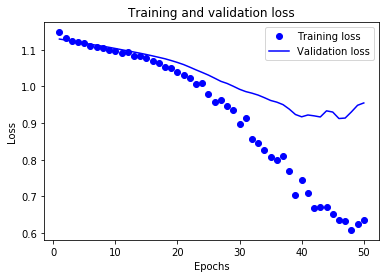

In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

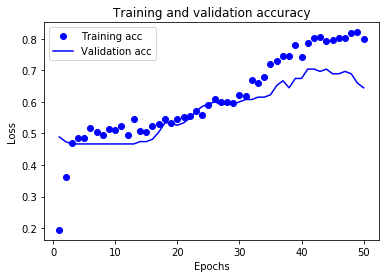

In [47]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [48]:
print('Best Training Accuracy:', max(acc)*100, 'Epoch:', np.argmax(acc),
     'Best Validation Accuracy:', max(val_acc)*100, 'Epoch:', np.argmax(val_acc))
print('Lowest Training Loss value:', min(loss)*100, 'Epoch:', np.argmin(loss),
     'Lowest Validation Loss:', min(val_loss)*100, 'Epoch:', np.argmin(val_loss))

Best Training Accuracy: 82.03703699288545 Epoch: 48 Best Validation Accuracy: 70.37037045867355 Epoch: 40
Lowest Training Loss value: 60.85625489552816 Epoch: 47 Lowest Validation Loss: 91.25188805438854 Epoch: 45


### 1D CNN BEST MODEL TEST RESULTS:

In [49]:
# Some memory clean-up
K.clear_session()

In [50]:
model = Sequential()       
model.add(layers.Embedding(keys+1, 128, input_length=70))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [51]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [52]:
model.fit([X_train], y, verbose=0, epochs=40, 
          batch_size=128)

In [53]:
model.evaluate(X_test, to_categorical(y_test.as_matrix()+1))

225/225 [==============================] - 0s 454us/step


[0.9215851741366916, 0.7022222222222222]

In [54]:
y_train.as_matrix()+1
y_ = model.predict(X_test)
y_[-1] = [0,0,1]

In [55]:
f_macro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='macro')
f_micro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='micro')
print('F1 Score (Macro):', f_macro)
print('F1 Score (Micro):', f_micro)

F1 Score (Macro): 0.4914819376026272
F1 Score (Micro): 0.7022222222222222


/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [65]:
target_names = ['-1', '0', '1']
report = classification_report(to_categorical([np.argmax(x) for x in y_]), 
                               to_categorical(y_test.as_matrix()+1), target_names=target_names)
print(report)

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00         0
          0       0.77      0.82      0.79       108
          1       0.80      0.59      0.68       117

avg / total       0.79      0.70      0.73       225



/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## LSTM:

In [98]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=70))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 128)           402176    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 70, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 534,147
Trainable params: 534,147
Non-trainable params: 0
_________________________________________________________________


In [99]:
history = model.fit([X_train], y,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Train on 540 samples, validate on 135 samples
Epoch 1/50
540/540 [==============================] - 3s 5ms/step - loss: 1.0025 - acc: 0.4796 - val_loss: 0.9671 - val_acc: 0.4667
Epoch 2/50
540/540 [==============================] - 2s 3ms/step - loss: 0.8837 - acc: 0.5796 - val_loss: 0.9298 - val_acc: 0.5481
Epoch 3/50
540/540 [==============================] - 2s 3ms/step - loss: 0.8380 - acc: 0.6333 - val_loss: 0.8953 - val_acc: 0.6074
Epoch 4/50
540/540 [==============================] - 2s 3ms/step - loss: 0.7685 - acc: 0.6463 - val_loss: 0.8782 - val_acc: 0.6148
Epoch 5/50
540/540 [==============================] - 2s 3ms/step - loss: 0.6877 - acc: 0.7056 - val_loss: 0.8505 - val_acc: 0.6222
Epoch 6/50
540/540 [==============================] - 2s 3ms/step - loss: 0.5845 - acc: 0.7796 - val_loss: 0.8218 - val_acc: 0.6444
Epoch 7/50
540/540 [==============================] - 2s 3ms/step - loss: 0.4431 - acc: 0.8481 - val_loss: 0.8163 - val_acc: 0.6889
Epoch 8/50
540/540 [==========

In [100]:
# Plotting Loss & Accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

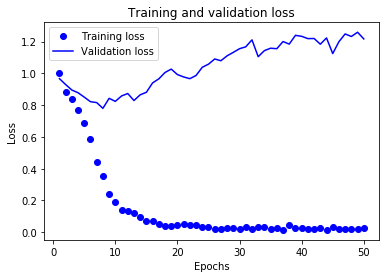

In [101]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

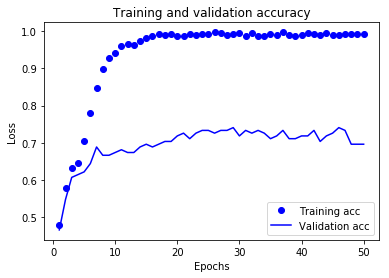

In [102]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [103]:
print('Best Training Accuracy:', max(acc)*100, 'Epoch:', np.argmax(acc),
     'Best Validation Accuracy:', max(val_acc)*100, 'Epoch:', np.argmax(val_acc))
print('Lowest Training Loss value:', min(loss)*100, 'Epoch:', np.argmin(loss),
     'Lowest Validation Loss:', min(val_loss)*100, 'Epoch:', np.argmin(val_loss))

Best Training Accuracy: 99.62962971793281 Epoch: 25 Best Validation Accuracy: 74.07407416237726 Epoch: 28
Lowest Training Loss value: 1.4628871323333845 Epoch: 36 Lowest Validation Loss: 78.00403162285133 Epoch: 7


### LSTM BEST MODEL TEST RESULTS:

In [112]:
# Some memory clean-up
K.clear_session()

In [105]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=70))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [106]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [107]:
model.fit([X_train], y, verbose=0, epochs=28, 
          batch_size=32)

In [108]:
model.evaluate(X_test, to_categorical(y_test.as_matrix()+1))

225/225 [==============================] - 0s 2ms/step


[1.1716262732611762, 0.6933333333333334]

In [109]:
y_train.as_matrix()+1
y_ = model.predict(X_test)
y_[-1] = [0,0,1]

In [110]:
f_macro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='macro')
f_micro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='micro')
print('F1 Score (Macro):', f_macro)
print('F1 Score (Micro):', f_micro)

F1 Score (Macro): 0.6122567287784679
F1 Score (Micro): 0.6933333333333334


In [111]:
target_names = ['-1', '0', '1']
report = classification_report(to_categorical([np.argmax(x) for x in y_]), 
                               to_categorical(y_test.as_matrix()+1), target_names=target_names)
print(report)

             precision    recall  f1-score   support

         -1       0.39      0.41      0.40        22
          0       0.77      0.78      0.77       114
          1       0.67      0.65      0.66        89

avg / total       0.69      0.69      0.69       225



## GRU RNN:

In [130]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=70))
model.add(GRU(128, dropout=0.2, return_sequences=True)) 
model.add(GRU(128, dropout=0.2))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 128)           402176    
_________________________________________________________________
gru_1 (GRU)                  (None, 70, 128)           98688     
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 599,939
Trainable params: 599,939
Non-trainable params: 0
_________________________________________________________________


In [131]:
history = model.fit([X_train], y,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Train on 540 samples, validate on 135 samples
Epoch 1/50
540/540 [==============================] - 4s 7ms/step - loss: 0.9541 - acc: 0.5019 - val_loss: 0.9670 - val_acc: 0.5926
Epoch 2/50
540/540 [==============================] - 2s 4ms/step - loss: 0.8043 - acc: 0.6315 - val_loss: 0.9088 - val_acc: 0.6148
Epoch 3/50
540/540 [==============================] - 2s 4ms/step - loss: 0.6418 - acc: 0.7056 - val_loss: 0.9439 - val_acc: 0.6148
Epoch 4/50
540/540 [==============================] - 2s 4ms/step - loss: 0.3735 - acc: 0.8778 - val_loss: 1.0605 - val_acc: 0.6519
Epoch 5/50
540/540 [==============================] - 2s 4ms/step - loss: 0.1875 - acc: 0.9389 - val_loss: 1.1708 - val_acc: 0.5926
Epoch 6/50
540/540 [==============================] - 2s 4ms/step - loss: 0.1126 - acc: 0.9667 - val_loss: 1.0976 - val_acc: 0.6593
Epoch 7/50
540/540 [==============================] - 2s 5ms/step - loss: 0.0652 - acc: 0.9870 - val_loss: 1.2214 - val_acc: 0.6889
Epoch 8/50
540/540 [==========

In [132]:
# Plotting Loss & Accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

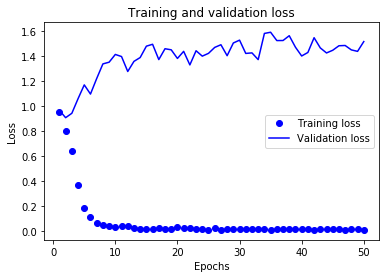

In [133]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

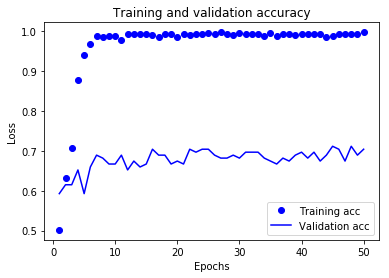

In [134]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [135]:
print('Best Training Accuracy:', max(acc)*100, 'Epoch:', np.argmax(acc),
     'Best Validation Accuracy:', max(val_acc)*100, 'Epoch:', np.argmax(val_acc))
print('Lowest Training Loss value:', min(loss)*100, 'Epoch:', np.argmin(loss),
     'Lowest Validation Loss:', min(val_loss)*100, 'Epoch:', np.argmin(val_loss))

Best Training Accuracy: 99.62962971793281 Epoch: 26 Best Validation Accuracy: 71.1111111994143 Epoch: 44
Lowest Training Loss value: 1.2413861785359956 Epoch: 49 Lowest Validation Loss: 90.88407825540614 Epoch: 1


### GRU RNN BEST MODEL TEST RESULTS:

In [136]:
# Some memory clean-up
K.clear_session()

In [137]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=70))
model.add(GRU(128, dropout=0.2, return_sequences=True)) 
model.add(GRU(128, dropout=0.2))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [138]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [139]:
model.fit([X_train], y, verbose=0, epochs=44, 
          batch_size=32)

In [140]:
model.evaluate(X_test, to_categorical(y_test.as_matrix()+1))

225/225 [==============================] - 0s 2ms/step


[1.7021820534600152, 0.6977777777777778]

In [141]:
y_train.as_matrix()+1
y_ = model.predict(X_test)
y_[-1] = [0,0,1]

In [142]:
f_macro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='macro')
f_micro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='micro')
print('F1 Score (Macro):', f_macro)
print('F1 Score (Micro):', f_micro)

F1 Score (Macro): 0.6114395720149234
F1 Score (Micro): 0.6977777777777778


In [143]:
target_names = ['-1', '0', '1']
report = classification_report(to_categorical([np.argmax(x) for x in y_]), 
                               to_categorical(y_test.as_matrix()+1), target_names=target_names)
print(report)

             precision    recall  f1-score   support

         -1       0.39      0.35      0.37        26
          0       0.76      0.77      0.77       114
          1       0.70      0.71      0.70        85

avg / total       0.69      0.70      0.70       225



## BiLSTM:

In [162]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=70))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 128)           402176    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 501,379
Trainable params: 501,379
Non-trainable params: 0
_________________________________________________________________


In [163]:
%%time
history = model.fit([X_train], y,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Train on 540 samples, validate on 135 samples
Epoch 1/50
540/540 [==============================] - 3s 6ms/step - loss: 0.9880 - acc: 0.4833 - val_loss: 0.9574 - val_acc: 0.4667
Epoch 2/50
540/540 [==============================] - 2s 3ms/step - loss: 0.8814 - acc: 0.5833 - val_loss: 0.9056 - val_acc: 0.6000
Epoch 3/50
540/540 [==============================] - 1s 3ms/step - loss: 0.8252 - acc: 0.6296 - val_loss: 0.8922 - val_acc: 0.6074
Epoch 4/50
540/540 [==============================] - 1s 3ms/step - loss: 0.7247 - acc: 0.6907 - val_loss: 0.8603 - val_acc: 0.6444
Epoch 5/50
540/540 [==============================] - 2s 3ms/step - loss: 0.5953 - acc: 0.7611 - val_loss: 0.8295 - val_acc: 0.6222
Epoch 6/50
540/540 [==============================] - 2s 3ms/step - loss: 0.4111 - acc: 0.8463 - val_loss: 0.8405 - val_acc: 0.6741
Epoch 7/50
540/540 [==============================] - 1s 3ms/step - loss: 0.2664 - acc: 0.9167 - val_loss: 0.8745 - val_acc: 0.7037
Epoch 8/50
540/540 [==========

In [164]:
# Plotting Loss & Accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

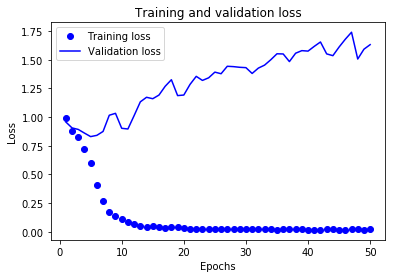

In [165]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

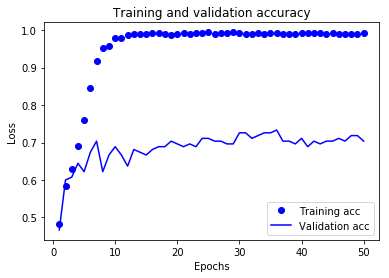

In [166]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [167]:
print('Best Training Accuracy:', max(acc)*100, 'Epoch:', np.argmax(acc),
     'Best Validation Accuracy:', max(val_acc)*100, 'Epoch:', np.argmax(val_acc))
print('Lowest Training Loss value:', min(loss)*100, 'Epoch:', np.argmin(loss),
     'Lowest Validation Loss:', min(val_loss)*100, 'Epoch:', np.argmin(val_loss))

Best Training Accuracy: 99.44444453274762 Epoch: 24 Best Validation Accuracy: 73.33333342163651 Epoch: 35
Lowest Training Loss value: 1.5841412687398218 Epoch: 40 Lowest Validation Loss: 82.95473262115762 Epoch: 4


### BiLSTM BEST MODEL TEST RESULTS:

In [168]:
# Some memory clean-up
K.clear_session()

In [169]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=70))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [170]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [171]:
model.fit([X_train], y, verbose=0, epochs=35, 
          batch_size=32)

In [172]:
model.evaluate(X_test, to_categorical(y_test.as_matrix()+1))

225/225 [==============================] - 0s 2ms/step


[1.3010617701212566, 0.7377777777777778]

In [173]:
y_train.as_matrix()+1
y_ = model.predict(X_test)
y_[-1] = [0,0,1]

In [174]:
f_macro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='macro')
f_micro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='micro')
print('F1 Score (Macro):', f_macro)
print('F1 Score (Micro):', f_micro)

F1 Score (Macro): 0.636815403528821
F1 Score (Micro): 0.7377777777777778


In [175]:
target_names = ['-1', '0', '1']
report = classification_report(to_categorical([np.argmax(x) for x in y_]), 
                               to_categorical(y_test.as_matrix()+1), target_names=target_names)
print(report)

             precision    recall  f1-score   support

         -1       0.26      0.75      0.39         8
          0       0.78      0.79      0.78       114
          1       0.81      0.68      0.74       103

avg / total       0.77      0.74      0.75       225

